In [1]:
import os
import sys

# This is to force the path to be on the same level as the dl_ba folder
sys.path.append("../..")

from transformers import AutoTokenizer
import torch
from datasets import load_dataset

import time

from balm import common_utils
from balm.models.utils import load_trained_model, load_pretrained_pkd_bounds
from balm.configs import Configs
from balm.models import BALM

DEVICE = "cpu"

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_hyperparameters" in ModelConfigs has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_configs" in Configs has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


# Load Pretrained BindingDB BALM

In [2]:
config_filepath = "../../default_configs/balm_peft.yaml"
configs = Configs(**common_utils.load_yaml(config_filepath))

# Load the model
model = BALM(configs.model_configs)
model = load_trained_model(model, configs.model_configs, is_training=False)
model.to(DEVICE)
model.eval()
# Pretrained pKd lower and upper bounds
pkd_lower_bound, pkd_upper_bound = load_pretrained_pkd_bounds(configs.model_configs.checkpoint_path)

# Load the tokenizers
protein_tokenizer = AutoTokenizer.from_pretrained(
    configs.model_configs.protein_model_name_or_path
)
drug_tokenizer = AutoTokenizer.from_pretrained(
    configs.model_configs.drug_model_name_or_path
)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 128,160 || all params: 148,923,641 || trainable%: 0.0861
trainable params: 221,184 || all params: 3,648,624 || trainable%: 6.0621
Loading checkpoint from BALM/bdb-cleaned-r-esm-lokr-chemberta-loha-cosinemse
Merging protein model with its adapter
Merging drug model with its adapter


# Custom Dummy Data

Alternative to loading the data from a HF repo, you can also bring in your own custom data.

In [5]:
import pandas as pd

df = pd.read_csv("custom_data_demo.csv")

In [6]:
# Adjust the column name to your data, this example has `Drug`, `Target`, `Y` columns denoting ligand sequences, protein sequences, and binding affinity respectively.
df.head(5)

,Index,Drug,Target,Y
0,0,O=C([O-])c1[nH]c2ccccc2c1CCCOc1ccccc1,GDELYRQSLEIISRYLREQATGAKDTKPMGRSGATSRKALETLRRV...,4.455932
1,1,Cc1ccccc1OCCCc1c(C(=O)[O-])[nH]c2ccccc12,GDELYRQSLEIISRYLREQATGAKDTKPMGRSGATSRKALETLRRV...,4.823909
2,2,Cc1cccc(OCCCc2c(C(=O)[O-])[nH]c3ccccc23)c1,GDELYRQSLEIISRYLREQATGAKDTKPMGRSGATSRKALETLRRV...,5.721246
3,3,O=C([O-])c1[nH]c2ccccc2c1CCCOc1cccc(C(F)(F)F)c1,GDELYRQSLEIISRYLREQATGAKDTKPMGRSGATSRKALETLRRV...,5.769551
4,4,Cc1ccc(OCCCc2c(C(=O)[O-])[nH]c3ccccc23)cc1,GDELYRQSLEIISRYLREQATGAKDTKPMGRSGATSRKALETLRRV...,4.795880


### Zero shot predictions with pretrained BindingDB

In [7]:
start = time.time()
predictions = []
labels = []
for _, sample in df.iterrows():
    # Prepare input
    protein_inputs = protein_tokenizer(sample["Target"], return_tensors="pt").to(DEVICE)
    drug_inputs = drug_tokenizer(sample["Drug"], return_tensors="pt").to(DEVICE)
    inputs = {
        "protein_input_ids": protein_inputs["input_ids"],
        "protein_attention_mask": protein_inputs["attention_mask"],
        "drug_input_ids": drug_inputs["input_ids"],
        "drug_attention_mask": drug_inputs["attention_mask"],
    }
    prediction = model(inputs)["cosine_similarity"]
    prediction = model.cosine_similarity_to_pkd(prediction, pkd_upper_bound=pkd_upper_bound, pkd_lower_bound=pkd_lower_bound)
    label = torch.tensor([sample["Y"]])

    print(f"Predicted pKd: {prediction.item()} | True pKd: {label.item()}")
    predictions.append(prediction.item())
    labels.append(label.item())
print(f"Time taken for 100 protein-ligand pairs: {time.time() - start}")

Predicted pKd: 4.687337875366211 | True pKd: 4.455932140350342
Predicted pKd: 4.799520492553711 | True pKd: 4.823908805847168
Predicted pKd: 4.840061664581299 | True pKd: 5.721246242523193
Predicted pKd: 4.6916422843933105 | True pKd: 5.7695512771606445
Predicted pKd: 4.794649600982666 | True pKd: 4.79587984085083
Predicted pKd: 4.777118682861328 | True pKd: 5.0087738037109375
Predicted pKd: 4.694001197814941 | True pKd: 5.004364967346191
Predicted pKd: 4.922251224517822 | True pKd: 6.4202165603637695
Predicted pKd: 4.802126884460449 | True pKd: 5.958607196807861
Predicted pKd: 5.07747745513916 | True pKd: 6.522878646850586
Predicted pKd: 4.931079864501953 | True pKd: 5.12493896484375
Predicted pKd: 4.930351734161377 | True pKd: 5.537601947784424
Predicted pKd: 5.17240047454834 | True pKd: 4.207608222961426
Predicted pKd: 5.050621509552002 | True pKd: 4.853871822357178
Predicted pKd: 5.165882110595703 | True pKd: 6.091515064239502
Predicted pKd: 5.262083053588867 | True pKd: 6.79587984

RMSE: 1.207031488418579
Pearson: 0.34085506200790405
Spearman: 0.3638461538461538
CI: 0.6266666650772095


Text(0, 0.5, 'Predicted $pK_d$')

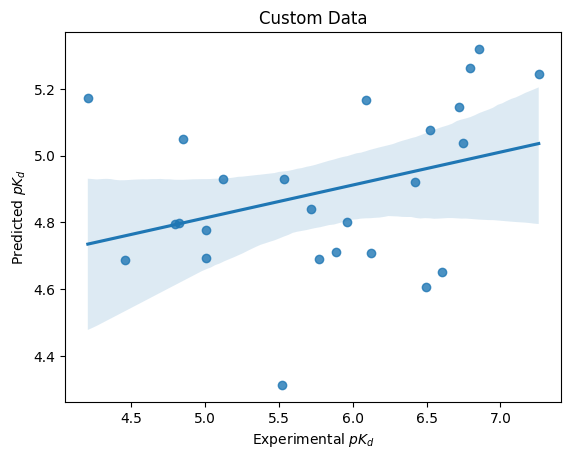

In [8]:
from balm.metrics import get_ci, get_pearson, get_rmse, get_spearman

import seaborn as sns

rmse = get_rmse(torch.tensor(labels), torch.tensor(predictions))
pearson = get_pearson(torch.tensor(labels), torch.tensor(predictions))
spearman = get_spearman(torch.tensor(labels), torch.tensor(predictions))
ci = get_ci(torch.tensor(labels), torch.tensor(predictions))

print(f"RMSE: {rmse}")
print(f"Pearson: {pearson}")
print(f"Spearman: {spearman}")
print(f"CI: {ci}")

ax = sns.regplot(x=labels, y=predictions)
ax.set_title(f"Custom Data")
ax.set_xlabel(r"Experimental $pK_d$")
ax.set_ylabel(r"Predicted $pK_d$")

# Few shot training

Note: This is a simplified training process, for a more tested approach, please refer to our `balm/trainer.py`

In [12]:
from sklearn.model_selection import train_test_split

# Split data
train_data, test_data = train_test_split(df, train_size=0.2, random_state=1234)

In [13]:
# Define a function that applies the cosine similarity conversion to a single example
# This is VERY IMPORTANT since BALM uses cosine similarity
def add_cosine_similarity(example, pkd_upper_bound, pkd_lower_bound):
    example['cosine_similarity'] = (
        (example['Y'] - pkd_lower_bound)
        / (pkd_upper_bound - pkd_lower_bound)
        * 2
        - 1
    )
    return example

# Use map to apply the function across the entire dataset
train_data = train_data.apply(lambda x: add_cosine_similarity(x, pkd_upper_bound, pkd_lower_bound), axis=1)
test_data = test_data.apply(lambda x: add_cosine_similarity(x, pkd_upper_bound, pkd_lower_bound), axis=1)

In [14]:
print(f"Number of train data: {len(train_data)}")
print(f"Number of test data: {len(test_data)}")

Number of train data: 5
Number of test data: 20


In [15]:
model = BALM(configs.model_configs)
model = load_trained_model(model, configs.model_configs, is_training=True)
model = model.to(DEVICE)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 128,160 || all params: 148,923,641 || trainable%: 0.0861
trainable params: 221,184 || all params: 3,648,624 || trainable%: 6.0621
Loading checkpoint from BALM/bdb-cleaned-r-esm-lokr-chemberta-loha-cosinemse
Merging protein model with its adapter
Merging drug model with its adapter
protein_projection.weight
protein_projection.bias
drug_projection.weight
drug_projection.bias
trainable params: 262,656 || all params: 152,485,577 || trainable%: 0.17224973349446682


In [16]:
from torch.optim import AdamW

NUM_EPOCHS = 10
optimizer = AdamW(
    params=[
        param
        for name, param in model.named_parameters()
    ],
    lr=configs.model_configs.model_hyperparameters.learning_rate,
)

start = time.time()
for epoch in range(NUM_EPOCHS):
    model.train()  # Set the model to training mode
    total_loss = 0.0  # To track the loss for each epoch

    for _, sample in train_data.iterrows():
        # Prepare input
        protein_inputs = protein_tokenizer(sample["Target"], return_tensors="pt").to(DEVICE)
        drug_inputs = drug_tokenizer(sample["Drug"], return_tensors="pt").to(DEVICE)
        # Move labels to the appropriate device and ensure it's a tensor
        labels = torch.tensor([sample["cosine_similarity"]], dtype=torch.float32).to(DEVICE)

        inputs = {
            "protein_input_ids": protein_inputs["input_ids"],
            "protein_attention_mask": protein_inputs["attention_mask"],
            "drug_input_ids": drug_inputs["input_ids"],
            "drug_attention_mask": drug_inputs["attention_mask"],
            "labels": labels,  # Add labels for training
        }

        # Forward pass
        outputs = model(inputs)

        # Assume the model's output dictionary contains 'loss'
        loss = outputs["loss"]

        # Backpropagation
        optimizer.zero_grad()  # Zero out the gradients to avoid accumulation
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        total_loss += loss.item()
    
    # Log the loss for this epoch
    avg_loss = total_loss / len(train_data)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}")

print("Training complete! Time taken: ", time.time() - start)

Epoch [1/10], Loss: 0.0915
Epoch [2/10], Loss: 0.0751
Epoch [3/10], Loss: 0.0562
Epoch [4/10], Loss: 0.0510
Epoch [5/10], Loss: 0.0424
Epoch [6/10], Loss: 0.0499
Epoch [7/10], Loss: 0.0451
Epoch [8/10], Loss: 0.0357
Epoch [9/10], Loss: 0.0415
Epoch [10/10], Loss: 0.0379
Training complete! Time taken:  92.83397889137268


## Test the model!

In [ ]:
model = model.eval()

predictions = []
labels = []
for _, sample in test_data.iterrows():
    # Prepare input
    protein_inputs = protein_tokenizer(sample["Target"], return_tensors="pt").to(DEVICE)
    drug_inputs = drug_tokenizer(sample["Drug"], return_tensors="pt").to(DEVICE)
    inputs = {
        "protein_input_ids": protein_inputs["input_ids"],
        "protein_attention_mask": protein_inputs["attention_mask"],
        "drug_input_ids": drug_inputs["input_ids"],
        "drug_attention_mask": drug_inputs["attention_mask"],
    }
    prediction = model(inputs)["cosine_similarity"]
    prediction = model.cosine_similarity_to_pkd(prediction, pkd_upper_bound=pkd_upper_bound, pkd_lower_bound=pkd_lower_bound)
    label = torch.tensor([sample["Y"]])

    print(f"Predicted pKd: {prediction.item()} | True pKd: {label.item()}")
    predictions.append(prediction.item())
    labels.append(label.item())
print(f"Time taken for {len(test_data)} protein-ligand pairs: {time.time() - start}")

Predicted pKd: 5.468099594116211 | True pKd: 6.4202165603637695
Predicted pKd: 5.780290603637695 | True pKd: 6.721246242523193
Predicted pKd: 5.39955997467041 | True pKd: 5.721246242523193
Predicted pKd: 5.2336320877075195 | True pKd: 5.7695512771606445
Predicted pKd: 5.301002502441406 | True pKd: 4.823908805847168
Predicted pKd: 5.795860767364502 | True pKd: 6.744727611541748
Predicted pKd: 5.259094715118408 | True pKd: 5.0087738037109375
Predicted pKd: 5.335289478302002 | True pKd: 4.79587984085083
Predicted pKd: 5.144143581390381 | True pKd: 4.455932140350342
Predicted pKd: 5.362062454223633 | True pKd: 5.958607196807861
Predicted pKd: 5.456796646118164 | True pKd: 4.853871822357178
Predicted pKd: 5.635218620300293 | True pKd: 6.602059841156006
Predicted pKd: 5.3519606590271 | True pKd: 5.12493896484375
Predicted pKd: 5.592774391174316 | True pKd: 6.12493896484375
Predicted pKd: 5.414948463439941 | True pKd: 6.494850158691406


In [ ]:
from balm.metrics import get_ci, get_pearson, get_rmse, get_spearman

rmse = get_rmse(torch.tensor(labels), torch.tensor(predictions))
pearson = get_pearson(torch.tensor(labels), torch.tensor(predictions))
spearman = get_spearman(torch.tensor(labels), torch.tensor(predictions))
ci = get_ci(torch.tensor(labels), torch.tensor(predictions))

print(f"RMSE: {rmse}")
print(f"Pearson: {pearson}")
print(f"Spearman: {spearman}")
print(f"CI: {ci}")

ax = sns.regplot(x=labels, y=predictions)
ax.set_title(f"Custom Data")
ax.set_xlabel(r"Experimental $pK_d$")
ax.set_ylabel(r"Predicted $pK_d$")